# Inverted pendulum: problem description
$
%%%%PREAMBLE%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Arrow notation
\newcommand{\ra}{\rightarrow}
\newcommand{\rra}{\rightrightarrows}
\newcommand{\la}{\leftarrow}
% \newcommand{\red}[1]{\textcolor{red}{#1}}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Abbreviations
\newcommand{\ie}{\unskip, i.\,e.,\xspace}
\newcommand{\eg}{\unskip, e.\,g.,\xspace}
\newcommand{\pd}{p.\,d.\xspace}
\newcommand{\sut}{\text{s.\,t.\,}}
\newcommand{\rt}{r.\,t.\xspace}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Wraps
\newcommand{\nrm}[1]{\left\lVert#1\right\rVert}
\newcommand{\diag}[1]{{\text{diag}}\left(#1\right)}
\newcommand{\abs}[1]{\left\lvert#1\right\rvert}
\newcommand{\scal}[1]{\left\langle#1\right\rangle}
\newcommand{\tr}[1]{{\text{tr}}\left(#1\right)}
\newcommand{\E}[1]{\mathbb E\left[#1\right]}
\newcommand{\PP}[1]{\mathbb P\left[#1\right]}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Set notation
\renewcommand{\N}{{\mathbb{N}}}
\renewcommand{\Z}{{\mathbb{Z}}}
\newcommand{\Q}{{\mathbb{Q}}}
\renewcommand{\R}{{\mathbb{R}}}
\newcommand{\T}{{\mathbb{T}}}
\newcommand{\X}{{\mathbb{X}}}
\newcommand{\Y}{{\mathbb{Y}}}
\newcommand{\F}{{\mathbb{F}}}
\newcommand{\U}{{\mathbb{U}}}
%\renewcommand{\U}{{\mathbb{U}}}
\newcommand{\sm}{{\setminus}}
\renewcommand{\set}[1]{{\mathbb{#1}}}
% \let\oldemptyset\emptyset
% \let\emptyset\varnothing
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Colored
% \newcommand{\red}[1]{\textcolor{red}{#1}}
% \newcommand{\blue}[1]{\textcolor{blue}{#1}}
% \definecolor{dgreen}{rgb}{0.0, 0.5, 0.0}
% \newcommand{\green}[1]{\textcolor{dgreen}{#1}}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Miscellaneous commands
\newcommand{\diff}{\mathop{}\!\mathrm{d}}
\newcommand{\eps}{{\varepsilon}}
\newcommand{\sgn}{{\text{sgn}}}
\newcommand{\spc}{{\,\,}}
\newcommand{\diam}{{\text{diam}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\ramp}{{\text{ramp}}}
\newcommand{\pdiff}[2]{ { \frac{\partial {#1}}{\partial {#2}} } }
\newcommand{\ball}{{\mathcal B}}
% \newcommand\circled[1]{\tikz[baseline=(char.base)]{\node[shape=circle,draw,inner sep=1pt](char){#1};}}
\newcommand{\co}{{\overline{\text{co}}}}
% \newcommand{\argmin}{\arg\min}
% \newcommand{\argmax}{arg\,max}
\newcommand{\lineZ}{\overline{Z}}
\newcommand{\lineR}{\overline{R}}
\newcommand{\linez}{\overline{z}}
\newcommand{\EP}[2]{\mathbb E_{#1}\left[#2\right]}
$

Here we consider a learning control for upswinging the inverted pendulum described by:
$$
    \begin{aligned}
        & \dot{\vartheta} = \omega, \\
        & \dot{\omega} = \frac{g}{l} \sin(\vartheta) + \frac{u}{m l^2}.
    \end{aligned}
    \qquad u \in [U_{\min}, U_{\max}]
$$
where $m$ is pendulum mass, $l$ is the pendulum length.
We assume the starting position of the pendulum down at rest:
$$
    \begin{aligned}
        & \vartheta(0) = \pi, \\
        & \omega(0) = 0.
    \end{aligned}    
$$


The formal goal of control reads:
$$
    \vartheta \ra 0 \qquad \omega  \ra 0.
$$

We will try to achieve this using a stochastic control policy defined by a model $\rho^\theta(u|\vartheta, \omega)$ with weights $\theta$ conditioned on the current *state* $(\vartheta, \omega)$ while optimizing some running cost $r$ which we will diccuss later.
We will treat this $\rho^\theta$ as a probability distribution and will sample the controls (actions) $u$ from $\rho^\theta$
Where necessary, we will stress the randomness of actions by capital letters like $U$.

There are many traditional control methods to achieve the state goal, including those based on the model.
In this notebook, we will pursue a different route: we will learn from pure experience by repeatedly running the pendulum and adjusting the model weights $\theta$.

To assess the performance of our learned policy, we will penalize it by a running cost function as follows:

$$
r(\vartheta, \omega, u) = \vartheta^2 + \omega^2
$$

**Remark 1**

Note that during lectures $r$ was denoted as reward function $r: \Y \times \U \rightarrow \R$.
In this notebook we denote $r$ as cost function $r: \Y \times \U \rightarrow \R$. This changes almost nothing for us, because one can easily
transform any reward function $r$ to the cost function via putting $r := -r$ and vice versa.

**Remark 2**

In general $r(\cdot)$ can depend on $u$, but in our case we do not put cost on action $u$. We tried to run the notebook with the following objective
$$
r(\vartheta, \omega, u) = \vartheta^2 + \omega^2 + u ^ 2.
$$
The algorithm may converge successfully with $\vartheta \ra 0$, $\omega  \ra 0$, but in most cases it converges to local minimum with the folowing structure.
$$
    \vartheta \ra \operatorname{const} \neq 0 \qquad \omega \ra 0
$$
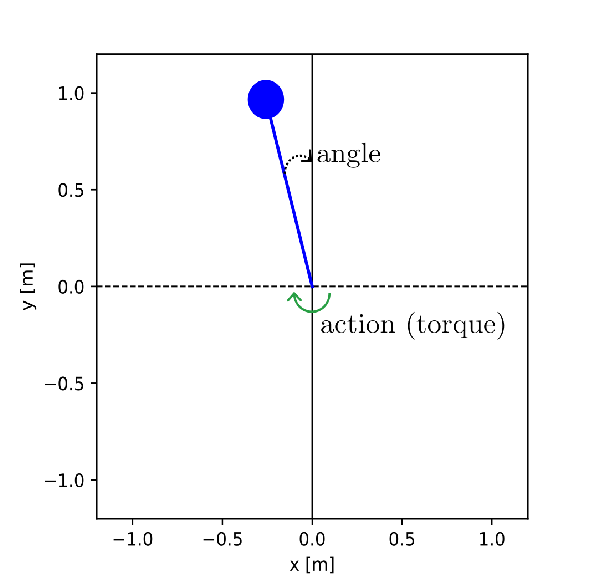

## Policy

The policy model will be taken as:
$$
\rho^{\theta}(u \mid \vartheta, \omega) = \mathsf{pdf}_{\mathcal{N}\left(\lambda \mu_{\theta}(y) + \beta, \lambda^2\sigma^2\right)}(u) = \mathsf{pdf}_{\mathcal{N}\left(\mu_{\theta}(y), \sigma^2\right)}\left(\frac{u - \beta}{\lambda}\right)
$$

where $ \mathsf{pdf}_{\mathcal{N}(\bullet_1, \bullet_2)} $ refers to the normal probability density with mean $\bullet_1$ and (co)variance $\bullet_2$, $\beta = \frac{U_{\min} + U_{\max}}{2}$, $\lambda = \frac{U_{\max} - U_{\min}}{2}$ and
the $\mu_{\theta}(\cdot)$ is a perceptron with weights $\theta$:
$$
    \mu_{\theta}(y) = y \ra \text{Linear(2, 4)} \ra \text{LeakyReLU(0.2)} \ra \text{Linear(4, 4)} \ra \text{LeakyReLU(0.2)} \ra \text{Linear(4, 1)} \ra (1 - 3\sigma) \tanh\left(\frac{\cdot}{L}\right)
$$
##### Remarks
 - Hyperparameter $L$ is merely a tuning parameter and does not posess a physical meaning.
 - $\mathsf{pdf}_{\mathcal{N}\left(\lambda \mu_{\theta}(y) + \beta, \lambda^2\sigma^2\right)}(u) = \mathsf{pdf}_{\mathcal{N}\left(\mu_{\theta}(y), \sigma^2\right)}\left(\frac{u - \beta}{\lambda}\right)$ due to $\lambda \xi + \beta \sim \mathcal{N}\left(\lambda \mu_{\theta}(y) + \beta, \lambda^2\sigma^2\right)$ for $\xi \sim \mathcal{N}\left(\mu_{\theta}(y), \sigma^2\right)$
 - Note that $\frac{u - \beta}{\lambda} \in [-1, 1]$ for $u \in [U_{\min}, U_{\max}]$. By construction $\mu_{\theta}(y) \in [-1 + 3\sigma, 1 - 3\sigma]$. Thus, the policy $\rho^{\theta}(u \mid \vartheta, \omega)$ samples actions that are within action bounds $[U_{\min}, U_{\max}]$ with propability greater than 99.86% by [3$\sigma$-rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule). This slight imprecision has no effect on efficiency.


# REINFORCE algorithm

General formula (you can find inference below implementation):

$$
  \boxed{
    \begin{array}{l}
    \hphantom{~}
    \\
    \theta_{i+1} \la \theta_{i} - \alpha_i \E{  \sum_{k = 0}^{N-1} \left( \sum_{k'=k}^{N-1} \gamma^{k'}r(Y_{k'}, U_{k'}) - B_k \right) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)\big|_{\theta=\theta^i}}
    \\
    \hphantom{~}
    \end{array}
  }.
$$
where $B_k$ is the so-called baseline --- a random variable independent on $(Y_k, U_k)$ (or in general case independent on $U_k$ conditioned on $Y_k$). For details we refer the reader to the [last section](#baseline) of the notebook.
 - [**Optional**] initialize baseline for the 1st iteration: $b^1 = 0.$

- **for** $i$ in $\{1, \dots, \mathcal I\}$: ($\mathcal I$ is the number of iterations (alternatively, you can use a stopping criterion).
Every iteration consists of $M$ episodes, i.e., Monte-Carlo runs)
>**for** $j$ in $\{1, \dots, M\}$: ($j$ is the number of episode, i.e., the number of a Monte-Carlo run)
>>
>> **for** $k$ in $\{0, \dots, N-1\}$: ($k$ is the number of step inside an episode)
>>>
>>> - obtain observation $y_k^j$ from the system
>>> - sample action $u_k^j$ from $\rho^{\theta}(u_k^j \mid y_k^j)$
> - [**optional**] compute a baseline for the next iteration, e.g., as previous means of tail objectives (a common choice):
$$
    b^{i + 1}_k \la \frac{1}{M} \sum_{j=1}^M \sum_{k'=k}^{N-1} \gamma^{k'} r(y_{k'}^j, u_{k'}^j)
$$ (it is our approach you can put any baseline you want)
> - perform a gradient step:
$$
    \theta_{i+1}
    \la
    \theta_i
    -
    \alpha_i
    \frac{1}{M}
    \sum_{j=1}^{M}
    \sum_{k=0}^{N-1}
        \left(\sum_{k'=k}^{N-1} \gamma^{k'} r\left(y_{k'}^j, u_{k'}^j\right) - b^i_k\right)
        \nabla_\theta \ln\rho^\theta(u_k^j \mid y_k^j)\big|_{\theta=\theta^i}
$$

**Remarks**.

- You can use a constant learning rate $\alpha$ throughout all the iterations, which should guarantee convergence in mean to a so called *noise ball* around a (local) optimizer, or use a *learning rate scheduler*, e.g., $\alpha_{i+1} \la \frac{\alpha}{\sqrt{i^2+1}}$ to achieve asymptotic convergence in mean.
In practice, too strong scheduler may fade away learning too much.
You can use some sophisticated scheduling in which you first do learning with a constant learning rate and then turn on the above scheduler.
- Simulation of the system can be done as $x_k^j \la x_{k-1}^j + \delta f(x_{k-1}^j, u_{k-1}^j)$ for $k \geq 1$, $\delta$ being the time step size and $x_0^j=$ `state_init`, where `state_init` = $\left(\pi, 0\right)$ in case of the inverted pendulum
- Baseline is very effective feature in REINFORCE.


# Implementation

The code is organized as follows. The main loop is implemented in `MonteCarloSimulationScenario` which starts REINFORCE learning procedure via `run` method. The main loop is organized as presented in previous section. During the main loop all observations, actions, running costs for every episode and step are collected in `IterationBuffer` object which is constructed in `PolicyREINFORCE`. After every iteration `MonteCarloSimulationScenario` calls `REINFORCE_step` method  which does gradient descent step as described above via calling the `optimize` method that is implemented in `Optimizer`. Moreover, there is additional functionality in `Optimizer` that enables to use learning rate schedulling (however, everything works even without scheduller).

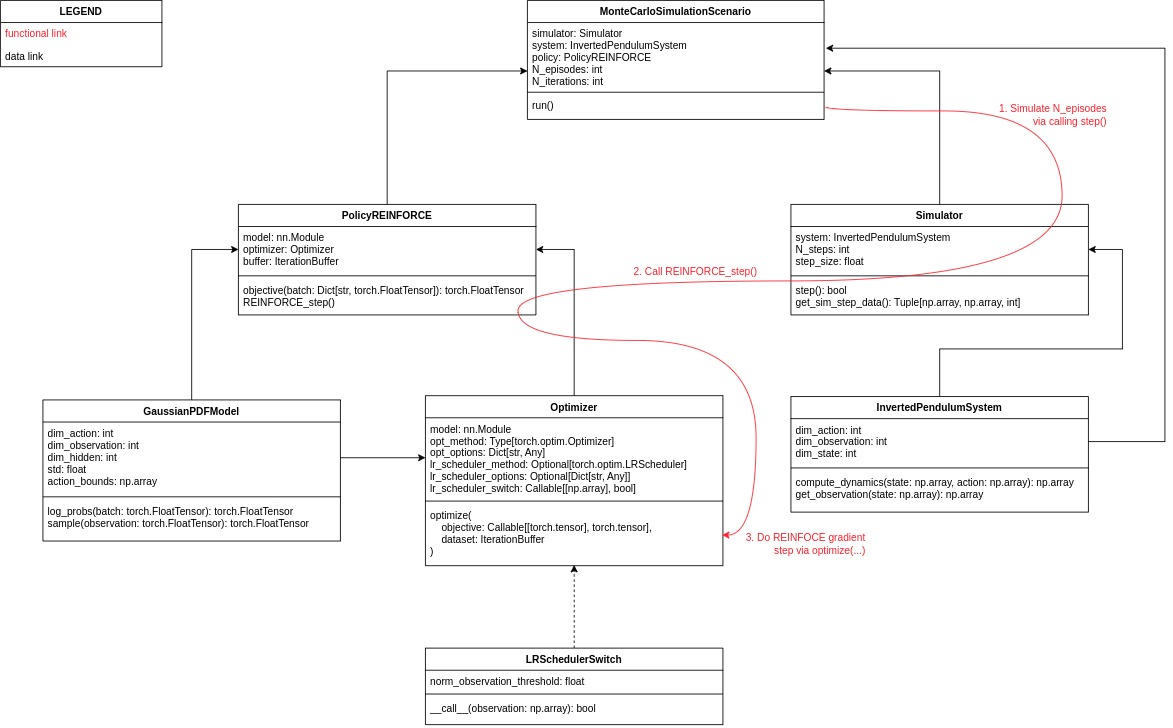


In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal
import random
from tqdm import tqdm
from typing import Tuple, Dict, Optional, Callable, Type, Any
from IPython.display import clear_output

# Problem 1. Implement right hand side of Inverted pendulum system

$$
    \begin{aligned}
        & \dot{\vartheta} = \omega, \\
        & \dot{\omega} = \frac{g}{l} \sin(\vartheta) + \frac{u}{m l^2}.
    \end{aligned}
    \qquad u \in [U_{\min}, U_{\max}]
$$

In [2]:
class InvertedPendulumSystem:
    """System class: inverted pendulum. State transition function"""

    dim_action: int = 1
    dim_observation: int = 2
    dim_state: int = 2

    m: float = 0.5
    l: float = 0.5
    g: float = 9.81

    def __init__(self) -> None:
        """Initialize `InvertedPendulumSystem`"""

        self.reset()

    def reset(self) -> None:
        """Reset system to inital state."""

        self.action = np.zeros(self.dim_action)

    def compute_dynamics(self, state: np.array, action: np.array) -> np.array:
        """Calculate right-hand-side for Euler integrator

        Args:
            state (np.array): current state
            action (np.array): current action

        Returns:
            np.array: right-hand-side for Euler integrator
        """

        Dstate = np.zeros(self.dim_observation)

        #-----------------------------------------------------------------------
        # HINT
        # Assume that Dstate is the right-hand side of the system dynamics
        # description, and assign proper values to the components of Dstate,
        # assuming that:
        #
        # Dstate[0] is \dot{\vartheta}
        # Dstate[1] is \dot{\omega}

        # YOUR CODE GOES HERE
        Dstate[0] = state[1]
        Dstate[1] = InvertedPendulumSystem.g / InvertedPendulumSystem.l * np.sin(state[0]) + action / InvertedPendulumSystem.m / (InvertedPendulumSystem.l ** 2)
        #-----------------------------------------------------------------------

        return Dstate

    def compute_closed_loop_rhs(self, state: np.array) -> np.array:
        """Get right-hand-side for current observation and saved `self.action`

        Args:
            state (np.array): current state

        Returns:
            np.array: right-hand-side for Euler integrator
        """

        system_right_hand_side = self.compute_dynamics(state, self.action)
        return system_right_hand_side

    def receive_action(self, action: np.array) -> None:
        """Save current action to `self.action`

        Args:
            action (np.array): current action
        """

        self.action = action

    @staticmethod
    def get_observation(state : np.array) -> np.array:
        """Get observation given a state

        Args:
            state (np.array): system state

        Returns:
            np.array: observation
        """
        observation = state

        return observation

## Simulator

Here we implement the Euler numerical integration scheme for our system.

In [3]:
class Simulator:
    """Euler integrator"""

    def __init__(
        self,
        system: InvertedPendulumSystem,
        N_steps: int,
        step_size: float,
        state_init: np.array,
    ):
        self.system = system
        self.N_steps = N_steps
        self.step_size = step_size
        self.state = np.copy(state_init)
        self.state_init = np.copy(state_init)
        self.current_step_idx = 0

    def step(self) -> bool:
        """Do one Euler integration step

        Returns:
            bool: status of simulation. `True` - simulation continues, `False` - simulation stopped
        """

        if self.current_step_idx <= self.N_steps:
            self.state += (
                self.system.compute_closed_loop_rhs(self.state) * self.step_size
            )
            self.current_step_idx += 1
            return True
        else:
            return False

    def reset(self) -> None:
        """Resets the system to initial state"""

        self.state = np.copy(self.state_init)
        self.current_step_idx = 0
        self.system.reset()

    def get_sim_step_data(self) -> Tuple[np.array, np.array, int]:
        """Get current observation, action and step id

        Returns:
            Tuple[np.array, np.array, int]:
        """

        return (
            self.system.get_observation(self.state),
            np.copy(self.system.action),
            int(self.current_step_idx),
        )

# Problem 1.2. Test your results

You have implemented the Inverted pendulum system. **Verify** that you have
done everything right. Compare your results with picture below. It should look exactly the same!

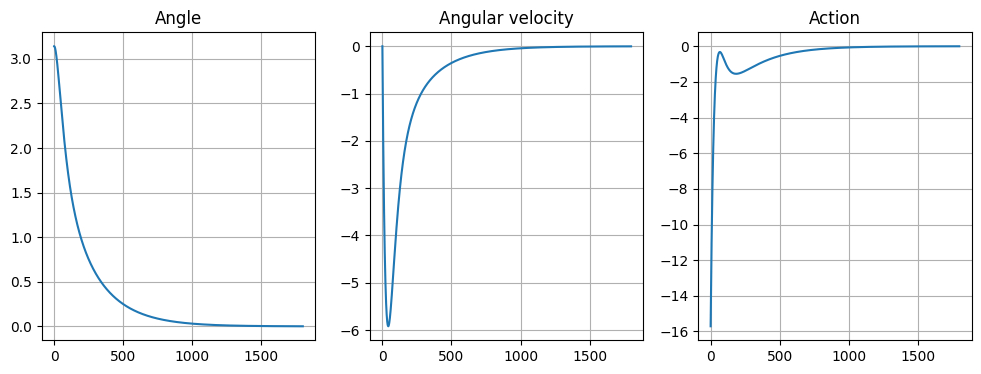

Text(0.5, 1.0, 'Action')

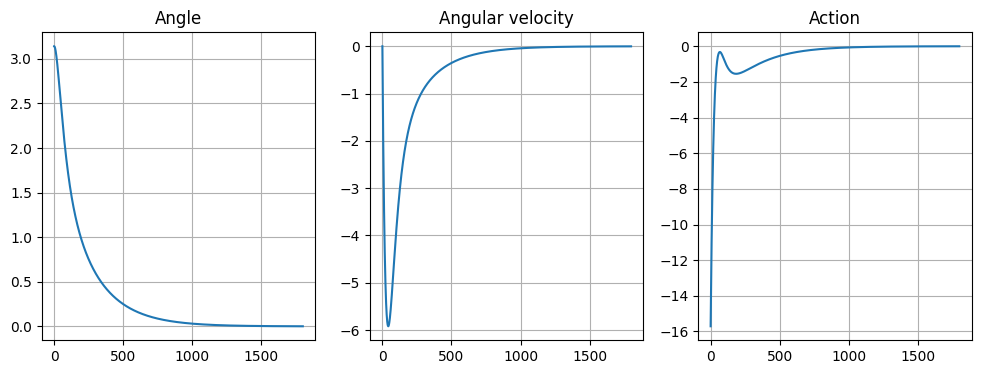

In [4]:
# RUN THIS!
system = InvertedPendulumSystem()
simulator = Simulator(
    system, N_steps=1800, step_size=0.003, state_init=np.array([np.pi, 0.0])
)
simulator.reset()

observations = []
actions = []
while simulator.step():
    (
        observation,
        action,
        step_idx,
    ) = simulator.get_sim_step_data()

    new_action = np.array([-5 * observation[0] + -2 * observation[1]])

    system.receive_action(new_action)
    observations.append(np.copy(observation))
    actions.append(np.copy(new_action))

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(12, 4)
ax1.plot(np.array(observations)[:, 0])
ax1.grid()
ax1.set_title("Angle")
ax2.plot(np.array(observations)[:, 1])
ax2.grid()
ax2.set_title("Angular velocity")
ax3.plot(np.array(actions)[:, 0])
ax3.grid()
ax3.set_title("Action")

## Experience replay

We need to save all our observations and actions for gradient descent step.

For this purpose, we implement `class IterationBuffer(Dataset)`

In [5]:
class IterationBuffer(Dataset):
    """Buffer for experience replay"""

    def __init__(self) -> None:
        """Initialize `IterationBuffer`"""

        super().__init__()
        self.next_baselines = None
        self.nullify_buffer()

    def nullify_buffer(self) -> None:
        """Clear all buffer data"""

        self.episode_ids = []
        self.observations = []
        self.actions = []
        self.running_objectives = []
        self.step_ids = []
        self.total_objectives = None
        self.baselines = None

    def add_step_data(
        self,
        observation: np.array,
        action: np.array,
        running_objective: float,
        step_id: int,
        episode_id: int,
    ):
        """Add step data to experience replay

        Args:
            observation (np.array): current observation
            action (np.array): current action
            running_objective (float): current running objective
            step_id (int): current step
            episode_id (int): current episode
        """
        self.observations.append(observation)
        self.actions.append(action)
        self.running_objectives.append(running_objective)
        self.episode_ids.append(int(episode_id))
        self.step_ids.append(step_id)

    def get_N_episodes(self) -> int:
        """Get number of episodes

        Returns:
            int: number of episodes
        """
        return len(np.unique(self.episode_ids))

    def calculate_tail_total_objectives_and_next_baselines(
        self,
    ) -> Tuple[np.array, float, float]:
        """Calculate tail total costs and baseline

        Returns:
            Tuple[np.array, float, float]: tuple of 3 elements tail_total_objectives, baseline, gradent_normalization_constant
        """

        unique_episode_ids = np.unique(self.episode_ids)
        running_objectives_series = pd.Series(
            index=self.episode_ids, data=self.running_objectives
        )

        tail_total_objectives = pd.concat(
            [
                running_objectives_series.loc[i][::-1].cumsum()[::-1]
                for i in unique_episode_ids
            ]
        ).values.reshape(-1)

        next_baselines = (
            pd.Series(index=self.step_ids, data=tail_total_objectives)
            .groupby(level=0)
            .mean()
            .loc[self.step_ids]
            .values.reshape(-1)
        )

        return tail_total_objectives, next_baselines

    def __len__(self) -> int:
        """Get length of buffer. The method should be overrided due to inheritance from `torch.utils.data.Dataset`

        Returns:
            int: length of buffer
        """
        return len(self.observations)

    def __getitem__(self, idx: int) -> Dict[str, torch.tensor]:
        """Get item with id `idx`. The method should be overrided due to inheritance from `torch.utils.data.Dataset`

        Args:
            idx (int): id of dataset item to return

        Returns:
            Dict[str, torch.tensor]: dataset item, containing catted observation-action, tail total objective and baselines
        """

        if self.total_objectives is None:
            self.baselines = (
                self.next_baselines
                if self.next_baselines is not None
                else np.zeros(shape=len(self.observations))
            )

            (
                self.total_objectives,
                self.next_baselines,
            ) = self.calculate_tail_total_objectives_and_next_baselines()

        observation = torch.tensor(self.observations[idx])
        action = torch.tensor(self.actions[idx])

        return {
            "observations_actions": torch.cat([observation, action]),
            "tail_total_objectives": torch.tensor(self.total_objectives[idx]),
            "baselines": torch.tensor(self.baselines[idx]),
        }

    @property
    def data(self) -> pd.DataFrame:
        """Return current buffer content in pandas.DataFrame

        Returns:
            pd.DataFrame: current buffer content
        """

        return pd.DataFrame(
            {
                "episode_id": self.episode_ids,
                "step_id": self.step_ids,
                "observation": self.observations,
                "action": self.actions,
                "running_objective": self.running_objectives,
            }
        )

## Problem 2. Model


The policy model will be taken as:
$$
\rho^{\theta}(u \mid \vartheta, \omega) = \mathsf{pdf}_{\mathcal{N}\left(\lambda \mu_{\theta}(y) + \beta, \lambda^2\sigma^2\right)}(u) = \mathsf{pdf}_{\mathcal{N}\left(\mu_{\theta}(y), \sigma^2\right)}\left(\frac{u - \beta}{\lambda}\right) = \texttt{Derive the exact form analytically}
$$

where $ \mathsf{pdf}_{\mathcal{N}(\bullet_1, \bullet_2)} $ refers to the normal probability density with mean $\bullet_1$ and (co)variance $\bullet_2$, $\beta = \frac{U_{\min} + U_{\max}}{2}$, $\lambda = \frac{U_{\max} - U_{\min}}{2}$ and
the $\mu_{\theta}(\cdot)$ is a perceptron with weights $\theta$:
$$
    \mu_{\theta}(y) = y \ra \text{Linear(2, 4)} \ra \text{LeakyReLU(0.2)} \ra \text{Linear(4, 4)} \ra \text{LeakyReLU(0.2)} \ra \text{Linear(4, 1)} \ra (1 - 3\sigma) \tanh\left(\frac{\cdot}{L}\right)
$$
##### Remarks
 - Hyperparameter $L$ is merely a tuning parameter and does not posess a physical meaning.
 - $\mathsf{pdf}_{\mathcal{N}\left(\lambda \mu_{\theta}(y) + \beta, \lambda^2\sigma^2\right)}(u) = \mathsf{pdf}_{\mathcal{N}\left(\mu_{\theta}(y), \sigma^2\right)}\left(\frac{u - \beta}{\lambda}\right)$ due to $\lambda \xi + \beta \sim \mathcal{N}\left(\lambda \mu_{\theta}(y) + \beta, \lambda^2\sigma^2\right)$ for $\xi \sim \mathcal{N}\left(\mu_{\theta}(y), \sigma^2\right)$
 - Note that $\frac{u - \beta}{\lambda} \in [-1, 1]$ for $u \in [U_{\min}, U_{\max}]$. By construction $\mu_{\theta}(y) \in [-1 + 3\sigma, 1 - 3\sigma]$. Thus, the policy $\rho^{\theta}(u \mid \vartheta, \omega)$ samples actions that are within action bounds $[U_{\min}, U_{\max}]$ with propability greater than 99.86% by [3$\sigma$-rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule). This slight imprecision has no effect on efficiency.

The model is based on `torch`'s `nn.Module`.
Thus, sampling from $\mathcal{N}\left(\lambda\mu_{\theta}(y) + \beta, \lambda^2\sigma^2\right)$
can be done out of the box.



Also `torch`'s auto-differentiator can compute gradients of $\ln \, \mathsf{pdf}_{\mathcal{N}\left(\lambda\mu_{\theta}(y) + \beta, \lambda^2\sigma^2\right)}(u) = \ln \rho^{\theta}(u | \vartheta, \omega)$ which is handy.



In [6]:
class Multiply(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha =  alpha
    
    def forward(self, x):
        x = torch.mul(x, self.alpha)
        return x

In [13]:
class GaussianPDFModel(nn.Module):
    """Model for REINFORCE algorithm that acts like f(x) + normally distributed noise"""

    def __init__(
        self,
        dim_observation: int,
        dim_action: int,
        dim_hidden: int,
        std: float,
        action_bounds: np.array,
        scale_factor: float,
        leakyrelu_coef=0.2,
    ):
        """Initialize model.

        Args:
            dim_observation (int): dimensionality of observation
            dim_action (int): dimensionality of action
            dim_hidden (int): dimensionality of hidden layer of perceptron (dim_hidden = 4 works for our case)
            std (float): standard deviation of noise (\\sigma)
            action_bounds (np.array): action bounds with shape (dim_action, 2). `action_bounds[:, 0]` - minimal actions, `action_bounds[:, 1]` - maximal actions
            scale_factor (float): scale factor for last activation (L coefficient) (see details above)
            leakyrelu_coef (float): coefficient for leakyrelu
        """

        super().__init__()

        self.dim_observation = dim_observation
        self.dim_action = dim_action
        self.dim_hidden = dim_hidden
        self.leakyrelu_coef = leakyrelu_coef
        self.std = std

        self.scale_factor = scale_factor
        self.register_parameter(
            name="scale_tril_matrix",
            param=torch.nn.Parameter(
                (self.std * torch.eye(self.dim_action)).float(),
                requires_grad=False,
            ),
        )
        self.register_parameter(
            name="action_bounds",
            param=torch.nn.Parameter(
                torch.tensor(action_bounds).float(),
                requires_grad=False,
            ),
        )


        #-----------------------------------------------------------------------
        # HINT
        #
        # Define your perceptron (or its layers) here
        #
        # TAs used nn.Sequential(...)
        # https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

        # YOUR CODE GOES HERE
        
        self.perceptron = nn.Sequential(
            nn.Linear(self.dim_observation, self.dim_hidden),
            nn.LeakyReLU(self.leakyrelu_coef),
            nn.Linear(self.dim_hidden, self.dim_hidden),
            nn.LeakyReLU(self.leakyrelu_coef),
            nn.Linear(self.dim_hidden, self.dim_action),
            Multiply(1 / self.scale_factor),
            nn.Tanh(),
            Multiply(1 - 3 * self.std)
        )
        #-----------------------------------------------------------------------



    def get_unscale_coefs_from_minus_one_one_to_action_bounds(
        self,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """Calculate coefficients for linear transformation from [-1, 1] to [U_min, U_max].

        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor]: coefficients
        """

        action_bounds = self.get_parameter("action_bounds")
        #-----------------------------------------------------------------------
        # HINT
        #
        # You need to return a tuple of \\beta, \\lambda
        #
        # Note that action bounds are denoted above as [U_max, U_min]
        #
        # YOUR CODE GOES HERE
        U_min, U_max = action_bounds[0]
        return (U_max + U_min) / 2, (U_max - U_min) / 2
        #-----------------------------------------------------------------------

    def unscale_from_minus_one_one_to_action_bounds(
        self, x: torch.FloatTensor
    ) -> torch.FloatTensor:
        """Linear transformation from [-1, 1] to [U_min, U_max].

        Args:
            x (torch.FloatTensor): tensor to transform

        Returns:
            torch.FloatTensor: transformed tensor
        """

        (
            unscale_bias,
            unscale_multiplier,
        ) = self.get_unscale_coefs_from_minus_one_one_to_action_bounds()

        return x * unscale_multiplier + unscale_bias

    def scale_from_action_bounds_to_minus_one_one(
        self, y: torch.FloatTensor
    ) -> torch.FloatTensor:
        """Linear transformation from [U_min, U_max] to [-1, 1].

        Args:
            y (torch.FloatTensor): tensor to transform

        Returns:
            torch.FloatTensor: transformed tensor
        """

        (
            unscale_bias,
            unscale_multiplier,
        ) = self.get_unscale_coefs_from_minus_one_one_to_action_bounds()

        return (y - unscale_bias) / unscale_multiplier

    def get_means(self, observations: torch.FloatTensor) -> torch.FloatTensor:
        """Return mean for MultivariateNormal from `observations`

        Args:
            observations (torch.FloatTensor): observations

        Returns:
            torch.FloatTensor: means
        """

        #-----------------------------------------------------------------------
        # HINT
        #
        # You should return here exactly the \\mu_theta(observations)
        # YOUR CODE GOES HERE
        return self.perceptron(observations.float())
        #-----------------------------------------------------------------------



    def split_to_observations_actions(
        self, observations_actions: torch.FloatTensor
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """Split input tensor to tuple of observation(s) and action(s)

        Args:
            observations_actions (torch.FloatTensor): tensor of catted observations actions to split

        Raises:
            ValueError: in case if `observations_actions` has dimensinality greater than 2

        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor]: tuple of observation(s) and action(s)
        """

        if len(observations_actions.shape) == 1:
            observation, action = (
                observations_actions[: self.dim_observation],
                observations_actions[self.dim_observation :],
            )
        elif len(observations_actions.shape) == 2:
            observation, action = (
                observations_actions[:, : self.dim_observation],
                observations_actions[:, self.dim_observation :],
            )
        else:
            raise ValueError("Input tensor has unexpected dims")

        return observation, action

    def log_probs(self, batch_of_observations_actions: torch.FloatTensor) -> torch.FloatTensor:
        """Get log pdf from the batch of observations actions

        Args:
            batch_of_observations_actions (torch.FloatTensor): batch of catted observations and actions

        Returns:
            torch.FloatTensor: log pdf(action | observation) for the batch of observations and actions
        """

        observations, actions = self.split_to_observations_actions(
            batch_of_observations_actions
        )

        scale_tril_matrix = self.get_parameter("scale_tril_matrix")

        #-----------------------------------------------------------------------
        # HINT
        # You should calculate pdf_Normal(\\lambda \\mu_theta(observations) + \\beta, \\lambda ** 2 \\sigma ** 2)(actions)
        #
        # TAs used not NormalDistribution, but MultivariateNormal
        # See here https://pytorch.org/docs/stable/distributions.html#multivariatenormal
        # YOUR CODE GOES HERE
        means = self.get_means(observations)
        distr = MultivariateNormal(means, scale_tril=scale_tril_matrix)
        return distr.log_prob(self.scale_from_action_bounds_to_minus_one_one(actions))
        #-----------------------------------------------------------------------


    def sample(self, observation: torch.FloatTensor) -> torch.FloatTensor:
        """Sample action from `MultivariteNormal(lambda * self.get_means(observation) + beta, lambda ** 2 * Diag[self.std] ** 2)`

        Args:
            observation (torch.FloatTensor): current observation

        Returns:
            torch.FloatTensor: sampled action
        """
        action_bounds = self.get_parameter("action_bounds")
        scale_tril_matrix = self.get_parameter("scale_tril_matrix")

        #-----------------------------------------------------------------------
        # HINT
        # Sample action from `MultivariateNormal(lambda * self.get_means(observation) + beta, lambda ** 2 * Diag[self.std] ** 2)
        # YOUR CODE GOES HERE
        distr = MultivariateNormal(self.get_means(observation), scale_tril=scale_tril_matrix)
        sampled_action = self.unscale_from_minus_one_one_to_action_bounds(distr.sample())
        #-----------------------------------------------------------------------
        
        return torch.clamp(
            sampled_action, action_bounds[:, 0], action_bounds[:, 1]
        )

## Utilities for optimizer

In [8]:
class LRSchedulerSwitch:
    """Callable class that returns True in case ||observation|| <= norm_observation_threshold"""

    def __init__(self, norm_observation_threshold: float) -> None:
        """Initialize LRSchedulerSwitch.

        Args:
            norm_observation_threshold (float): threshold for observation norm
        """
        self.norm_observation_threshold = norm_observation_threshold
        self.turned_on = False

    def __call__(self, observation: np.array) -> bool:
        """Return True if ||observation|| <= norm_observation_threshold

        Args:
            observation (np.array): observation

        Returns:
            bool: ||observation|| <= norm_observation_threshold
        """

        if (
            self.turned_on
            or np.linalg.norm(observation) <= self.norm_observation_threshold
        ):
            self.turned_on = True
            return True
        else:
            return False


class Optimizer:
    """Does gradient step for optimizing model weights"""

    def __init__(
        self,
        model: nn.Module,
        opt_method: Type[torch.optim.Optimizer],
        opt_options: Dict[str, Any],
        lr_scheduler_method: Optional[torch.optim.lr_scheduler.LRScheduler] = None,
        lr_scheduler_options: Optional[Dict[str, Any]] = None,
        lr_scheduler_switch: Callable[[np.array], bool] = lambda _: True,
        shuffle: bool = True,
    ):
        """Initialize Optimizer

        Args:
            model (nn.Module): model which weights we need to optimize
            opt_method (Type[torch.optim.Optimizer]): method type for optimization. For instance, `opt_method=torch.optim.SGD`
            opt_options (Dict[str, Any]): kwargs dict for opt method
            lr_scheduler_method (Optional[torch.optim.lr_scheduler.LRScheduler], optional): method type for LRScheduler. Defaults to None
            lr_scheduler_options (Optional[Dict[str, Any]], optional): kwargs for LRScheduler. Defaults to None
            lr_scheduler_switch (Callable[[np.array], bool]): callable object for turning on the sheduller. Defaults to lambda _: True
            shuffle (bool, optional): whether to shuffle items in dataset. Defaults to True
        """

        self.opt_method = opt_method
        self.opt_options = opt_options
        self.shuffle = shuffle
        self.model = model
        self.optimizer = self.opt_method(self.model.parameters(), **self.opt_options)
        self.lr_scheduler_method = lr_scheduler_method
        self.lr_scheduler_options = lr_scheduler_options
        self.lr_scheduler_switch = lr_scheduler_switch
        if self.lr_scheduler_method is not None:
            self.lr_scheduler = self.lr_scheduler_method(
                self.optimizer, **self.lr_scheduler_options
            )
        else:
            self.lr_scheduler = None

    def optimize(
        self,
        objective: Callable[[torch.tensor], torch.tensor],
        dataset: IterationBuffer,
    ) -> None:
        """Do gradient step.

        Args:
            objective (Callable[[torch.tensor], torch.tensor]): objective to optimize
            dataset (Dataset): data for optmization
        """

        dataloader = DataLoader(
            dataset=dataset,
            shuffle=self.shuffle,
            batch_size=len(dataset),
        )
        batch_sample = next(iter(dataloader))
        self.optimizer.zero_grad()
        objective_value = objective(batch_sample)
        objective_value.backward()
        self.optimizer.step()

        last_observation = dataset.observations[-1]
        if self.lr_scheduler_switch(last_observation) and self.lr_scheduler is not None:
            self.lr_scheduler.step()

## Problem 3. Policy

In this task you need to calculate **surrogate** objective value here
$$
 \frac{1}{M}
    \sum_{j=1}^{M}
    \sum_{k=0}^{N-1}
        \left(\sum_{k'=k}^{N-1} \gamma^{k'} r\left(y_{k'}^j, u_{k'}^j\right) - b^i_k\right)
        \ln\rho^\theta(u_k^j \mid y_k^j)
$$

Note that we use the following notation in code

1. `N_episodes` is $M$
2. `observations_actions` is the batch of $(y_{k}^j, u_{k}^j)$ with shape ($M\times N$, `dim_observation` + `dim_action`).

3. `tail_total_objectives` is the batch of $\sum_{k'=k}^{N-1} \gamma^{k'} r\left(y_{k'}^j, u_{k'}^j\right)$ with shape ($M\times N$,)
4. `baselines` is the batch of baselines $b_k^i$ with shape  ($M\times N$,)

We store data in batch in the following order
$$
    \begin{matrix}
        \texttt{observations}\_\texttt{actions} & \texttt{tail}\_\texttt{total}\_\texttt{objectives} & \texttt{baselines} \\
        y_0^1, u_0^1 & \sum_{k'=0}^{N-1} \gamma^{k'} r\left(y_{k'}^1, u_{k'}^1\right) & b_0^i\\
        y_1^1, u_1^1 & \sum_{k'=1}^{N-1} \gamma^{k'} r\left(y_{k'}^1, u_{k'}^1\right) & b_1^i \\
        y_2^1, u_2^1 & \sum_{k'=2}^{N-1} \gamma^{k'} r\left(y_{k'}^1, u_{k'}^1\right) & b_2^i\\
        \vdots & \vdots & \vdots\\
        y_{N-1}^1, u_{N-1}^1 & \sum_{k'=N-1}^{N-1} \gamma^{k'} r\left(y_{k'}^1, u_{k'}^1\right) & b_{N-1}^i\\
        y_0^2, u_0^2 & \sum_{k'=0}^{N-1} \gamma^{k'} r\left(y_{k'}^2, u_{k'}^2\right) & b_0^i\\
        y_1^2, u_1^2 & \sum_{k'=1}^{N-1} \gamma^{k'} r\left(y_{k'}^2, u_{k'}^j\right) & b_1^i\\
        y_2^2, u_2^2 & \sum_{k'=2}^{N-1} \gamma^{k'} r\left(y_{k'}^2, u_{k'}^2\right) & b_2^i\\
        \vdots & \vdots & \vdots \\
        y_{N-1}^2, u_{N-1}^2 & \sum_{k'=N-1}^{N-1} \gamma^{k'} r\left(y_{k'}^2, u_{k'}^3\right) & b_{N-1}^i\\
        y_0^3, u_0^3 & \sum_{k'=0}^{N-1} \gamma^{k'} r\left(y_{k'}^3, u_{k'}^3\right) & b_0^i\\
        \vdots & \vdots & \vdots \\
        \vdots & \vdots & \vdots \\
        y_{N-1}^M, u_{N-1}^M & \sum_{k'=N-1}^{N-1} \gamma^{k'} r\left(y_{k'}^M, u_{k'}^M\right) & b_{N-1}^i
    \end{matrix}
$$

In [9]:
class PolicyREINFORCE:
    def __init__(
        self, model: nn.Module, optimizer: Optimizer, device: str = "cpu", is_with_baseline: bool = True,
    ) -> None:
        """Initialize policy

        Args:
            model (nn.Module): model to optimize
            optimizer (Optimizer): optimizer for `model` weights optimization
            device (str, optional): device for gradient descent optimization procedure. Defaults to "cpu".
            is_with_baseline (bool, optional): whether to use baseline in objective function.
        """

        self.buffer = IterationBuffer()
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.is_with_baseline = is_with_baseline

    def objective(self, batch: Dict["str", torch.tensor]) -> torch.tensor:
        """This method computes a proxy objective specifically for automatic differentiation since its gradient is exactly as in REINFORCE

        Args:
            batch (torch.tensor): batch with catted observations-actions, total objectives and baselines

        Returns:
            torch.tensor: objective value
        """

        observations_actions = batch["observations_actions"].to(self.device)
        tail_total_objectives = batch["tail_total_objectives"].to(self.device)
        baselines = batch["baselines"].to(self.device)

        #-----------------------------------------------------------------------
        # HINT
        # Return the surrogate objective value as described above
        # YOUR CODE GOES HERE
        log_probs = self.model.log_probs(observations_actions)
        return ((tail_total_objectives - baselines) * log_probs).sum() / self.N_episodes
        #-----------------------------------------------------------------------

    def REINFORCE_step(self) -> None:
        """Do gradient REINFORCE step"""

        self.N_episodes = self.buffer.get_N_episodes()
        self.model.to(self.device)
        self.optimizer.optimize(self.objective, self.buffer)
        self.model.to("cpu")
        self.buffer.nullify_buffer()

## Class for main loop

In [10]:
class MonteCarloSimulationScenario:
    """Run whole REINFORCE procedure"""

    def __init__(
        self,
        simulator: Simulator,
        system: InvertedPendulumSystem,
        policy: PolicyREINFORCE,
        N_episodes: int,
        N_iterations: int,
        discount_factor: float = 1.0,
        termination_criterion: Callable[
            [np.array, np.array, float, float], bool
        ] = lambda *args: False,
    ):
        """Initialize scenario for main loop


        Args:
            simulator (Simulator): simulator for computing system dynamics
            system (InvertedPendulumSystem): system itself
            policy (PolicyREINFORCE): REINFORCE gradient stepper
            N_episodes (int): number of episodes in one iteration
            N_iterations (int): number of iterations
            discount_factor (float, optional): discount factor for running objectives. Defaults to 1
            termination_criterion (Callable[[np.array, np.array, float, float], bool], optional): criterion for episode termination. Takes observation, action, running_objective, total_objectove. Defaults to lambda*args:False
        """

        self.simulator = simulator
        self.system = system
        self.policy = policy
        self.N_episodes = N_episodes
        self.N_iterations = N_iterations
        self.termination_criterion = termination_criterion
        self.discount_factor = discount_factor

        self.total_objective = 0
        self.total_objectives_episodic = []
        self.learning_curve = []
        self.last_observations = None

    def compute_running_objective(
        self, observation: np.array, action: np.array
    ) -> float:
        """Computes running objective

        Args:
            observation (np.array): current observation
            action (np.array): current action

        Returns:
            float: running objective value
        """
        return observation[0] ** 2 + observation[1] ** 2

    def run(self) -> None:
        """Run main loop"""

        eps = 0.1
        means_total_objectives = [eps]
        for iteration_idx in range(self.N_iterations):
            if iteration_idx % 10 == 0:
                clear_output(wait=True)
            for episode_idx in tqdm(range(self.N_episodes)):
                terminated = False
                while self.simulator.step():
                    (
                        observation,
                        action,
                        step_idx,
                    ) = self.simulator.get_sim_step_data()

                    new_action = (
                        self.policy.model.sample(torch.tensor(observation).float())
                        .detach()
                        .cpu()
                        .numpy()
                    )
                    discounted_running_objective = self.discount_factor ** (
                        step_idx
                    ) * self.compute_running_objective(observation, new_action)
                    self.total_objective += discounted_running_objective

                    if not terminated and self.termination_criterion(
                        observation,
                        new_action,
                        discounted_running_objective,
                        self.total_objective,
                    ):
                        terminated = True

                    if not terminated:
                        self.policy.buffer.add_step_data(
                            np.copy(observation),
                            np.copy(new_action),
                            np.copy(discounted_running_objective),
                            step_idx,
                            episode_idx,
                        )
                    self.system.receive_action(new_action)
                self.simulator.reset()
                self.total_objectives_episodic.append(self.total_objective)
                self.total_objective = 0
            self.learning_curve.append(np.mean(self.total_objectives_episodic))
            self.last_observations = pd.DataFrame(
                index=self.policy.buffer.episode_ids,
                data=self.policy.buffer.observations.copy(),
            )
            self.last_actions = pd.DataFrame(
                index=self.policy.buffer.episode_ids,
                data=self.policy.buffer.actions.copy(),
            )
            self.policy.REINFORCE_step()

            means_total_objectives.append(np.mean(self.total_objectives_episodic))
            change = (means_total_objectives[-1] / means_total_objectives[-2] - 1) * 100
            sign = "-" if np.sign(change) == -1 else "+"
            print(
                f"Iteration: {iteration_idx + 1} / {self.N_iterations}, "
                + f"mean total cost {round(means_total_objectives[-1], 2)}, "
                + f"% change: {sign}{abs(round(change,2))}, "
                + f"last observation: {self.last_observations.iloc[-1].values.reshape(-1)}",
                end="\n",
            )

            self.total_objectives_episodic = []

    def plot_data(self):
        """Plot learning results"""

        data = pd.Series(
            index=range(1, len(self.learning_curve) + 1), data=self.learning_curve
        )
        na_mask = data.isna()
        not_na_mask = ~na_mask
        interpolated_values = data.interpolate()
        interpolated_values[not_na_mask] = None
        data.plot(marker="o", markersize=3)
        interpolated_values.plot(linestyle="--")

        plt.title("Total cost by iteration")
        plt.xlabel("Iteration number")
        plt.ylabel("Total cost")
        plt.yscale("log")
        plt.show()

        theta_ax, dot_theta_ax = pd.DataFrame(
            data=self.last_observations.loc[0].values
        ).plot(
            xlabel="Step Number",
            title="Observations in last iteration",
            legend=False,
            subplots=True,
            grid=True,
        )
        theta_ax.set_ylabel("angle")
        dot_theta_ax.set_ylabel("angular velocity")

        actions_ax = pd.DataFrame(
            data=self.last_actions.loc[0].values
        ).plot(
            xlabel="Step Number",
            title="Actions in last iteration",
            legend=False,
            grid=True,
        )
        actions_ax.set_ylabel("action")

        plt.show()

## Problem 4. Fit REINFORCE

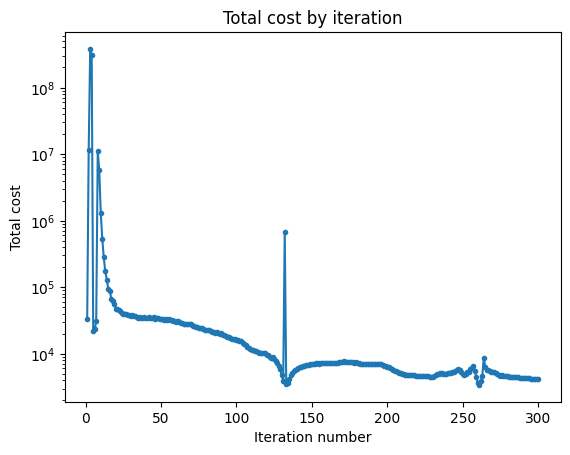

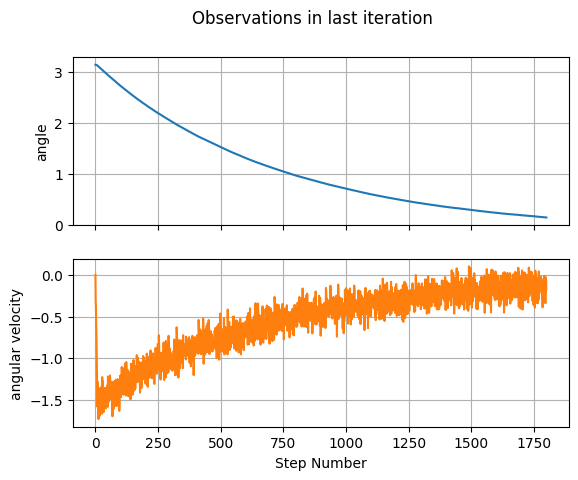

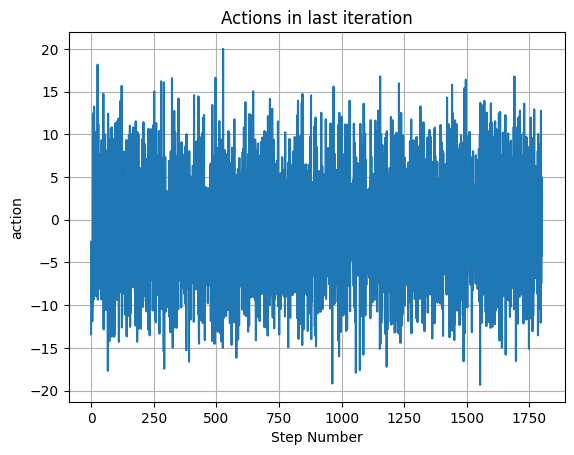

In [36]:
SEED = 14
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

system = InvertedPendulumSystem()
## DO NOT CHANGE THE PARAMS OF SIMULATOR.
simulator = Simulator(
    system, N_steps=1800, step_size=0.003, state_init=np.array([np.pi, 0.0])
)
model = GaussianPDFModel(
    dim_observation=system.dim_observation,
    dim_action=system.dim_action,
    action_bounds=np.array([[-20, 20]]),
    #---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    scale_factor=200,  # TRY TO FIND scale_factor EMPIRICALLY
    dim_hidden=6, # TRY TO FIND dim_hidden EMPIRICALLY
    std=0.2, # TRY TO FIND STD EMPIRICALLY
    #---------------------------------------------------------------------------
)

# optimizer = Optimizer(
#     model=model,
#     opt_method=torch.optim.Adam,
#     #---------------------------------------------------------------------------
#     # YOUR CODE GOES HERE
#     opt_options=dict(lr=0.03), # TRY TO FIND lr EMPIRICALLY
#     #---------------------------------------------------------------------------
# )
## Or if you want to use scheduler then initialize optimizer, via, for instance
lr_scheduler_fading_coeff = 1
optimizer = Optimizer(
    model=model,
    opt_method=torch.optim.Adam,
    opt_options=dict(lr=1.0, betas=(0.8, 0.9)),
    shuffle=False,
    lr_scheduler_method=torch.optim.lr_scheduler.MultiplicativeLR,
    lr_scheduler_options={
        "lr_lambda": lambda iteration: 1
        / np.sqrt((iteration / lr_scheduler_fading_coeff) ** 2 + 1)
    },
    lr_scheduler_switch=LRSchedulerSwitch(norm_observation_threshold=0.1),
)

# BELEIVE US! YOU CAN SOLVE THIS TASK WITHOUT SCHEDULER

policy = PolicyREINFORCE(model, optimizer, is_with_baseline=True)


# This termination criterion never terminates episodes
trivial_terminantion_criterion = lambda *args: False

## EXAMPLE. This termination criterion terminates episode if observation norm >= 20
#
# termination_criterion = (
#     lambda observation, action, running_objective, total_objective: (
#         np.linalg.norm(observation) >= 20
#     )
# )
#
# DO NOT USE TERMINATION CRITERION OTHER THAN trivial_termination_criterion


scenario = MonteCarloSimulationScenario(
    simulator=simulator,
    system=system,
    policy=policy,
    #---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    N_episodes=1, # Increasing the number of episodes stabilizes learning, but you can manage it with N_episodes=1
    N_iterations=300, # You can change the number of iterations if you want
    #---------------------------------------------------------------------------
    termination_criterion=trivial_terminantion_criterion,
    discount_factor=1.0, # do not change this
)

try:
    scenario.run()
except KeyboardInterrupt:
    clear_output(wait=True)
    scenario.plot_data()

clear_output(wait=True)
scenario.plot_data()

# Theory behind REINFORCE

## Notation


From now on we will use the following notation:

| Notation &nbsp; &nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;&nbsp; Description |
|:-----------------------:|-------------|
| $f(\cdot, \cdot, \cdot) : \R^{n+1}\times \R^{m} \ra \R^{n}$ |**state dynamic (or transition) function** which may refer to the right-hand side of a difference equation $x_{k+1} = f(k, x_k, u_k)$ or differential equation $\dot{x} = f(t, x, u)$ or a probability distribution $X_{k+1} \sim f(x_{k+1} \mid k, x_k, u_k)$
| $x \in \R^{n} $ | **State** |
| $u \in \R^{m}$ | **Action** |
| $y \in \R^{l}$ | **Observartion**|
| $\X \subseteq \R^{n} $| **State space**|
| $\U \subseteq \R^{m} $| **Action space**|
| $\Y \subseteq \R^{l} $| **Observation space**|
| $h(\cdot): \R^{n} \ra \R^{l}$ | **Observation function** that maps states $x$ to observation $y$, i.e., $y = h(x)$ |
| $\rho^{\theta}(\cdot \mid \cdot ) : \R^{m} \times \R^{l} \ra \R$ | **Policy** model (in general as a distribution) with weights $\theta$ |
| $r(\cdot, \cdot) : \R^{n} \times \R^{m} \ra \R$ | **Running objective**(cost) function  |

In case of inverted pendulum, say, $n = m = 2$, $l = 1$ and
$$
\begin{aligned}
  x & =  \left(\begin{array}{l} \vartheta \\ \omega \end{array}\right), \\
  h(x) & = x, \\
  f(t, x, u) & = \left(\begin{array}{l} \omega \\ \frac{g}{l} \sin(\vartheta) + \frac{u}{m l^2} \end{array}\right), u \in [U_{min}, U_{max}].
\end{aligned}
$$

We take the running cost in quadratic form:
$$
    r(\vartheta, \omega, u) = \vartheta^ 2 + \omega ^ 2.
$$

The policy model will be taken as:
$$
\rho^{\theta}(u \mid \vartheta, \omega) = \mathsf{pdf}_{\mathcal{N}\left(\lambda \mu_{\theta}(y) + \beta, \lambda^2\sigma^2\right)}(u) = \mathsf{pdf}_{\mathcal{N}\left(\mu_{\theta}(y), \sigma^2\right)}\left(\frac{u - \beta}{\lambda}\right)
$$

where $ \mathsf{pdf}_{\mathcal{N}(\bullet_1, \bullet_2)} $ refers to the normal probability density with mean $\bullet_1$ and (co)variance $\bullet_2$, $\beta = \frac{U_{\min} + U_{\max}}{2}$, $\lambda = \frac{U_{\max} - U_{\min}}{2}$ and
the $\mu_{\theta}(\cdot)$ is a perceptron with weights $\theta$:
$$
    \mu_{\theta}(y) = y \ra \text{Linear(2, 4)} \ra \text{LeakyReLU(0.2)} \ra \text{Linear(4, 4)} \ra \text{LeakyReLU(0.2)} \ra \text{Linear(4, 1)} \ra (1 - 3\sigma) \tanh\left(\frac{\cdot}{L}\right)
$$
##### Remarks
 - Hyperparameter $L$ is merely a tuning parameter and does not posess a physical meaning.
 - $\mathsf{pdf}_{\mathcal{N}\left(\lambda \mu_{\theta}(y) + \beta, \lambda^2\sigma^2\right)}(u) = \mathsf{pdf}_{\mathcal{N}\left(\mu_{\theta}(y), \sigma^2\right)}\left(\frac{u - \beta}{\lambda}\right)$ due to $\lambda \xi + \beta \sim \mathcal{N}\left(\lambda \mu_{\theta}(y) + \beta, \lambda^2\sigma^2\right)$ for $\xi \sim \mathcal{N}\left(\mu_{\theta}(y), \sigma^2\right)$
 - Note that $\frac{u - \beta}{\lambda} \in [-1, 1]$ for $u \in [U_{\min}, U_{\max}]$. By construction $\mu_{\theta}(y) \in [-1 + 3\sigma, 1 - 3\sigma]$. Thus, the policy $\rho^{\theta}(u \mid \vartheta, \omega)$ samples actions that are within action bounds $[U_{\min}, U_{\max}]$ with propability greater than 99.86% by [3$\sigma$-rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule). This slight imprecision has no effect on efficiency.



## Basics

Consider a system
$$
    X_{k + 1} \sim f(x_{k+1} \mid x_k, u_k), \quad Y_k = h(X_k), \quad U_{k} \sim \rho^{\theta}(u_{k} \mid y_k).
$$
If the observation function is trivial (an identity), we can just consider:
$$
    Y_{k+1} \sim f(y_{k+1} \mid y_k, u_k), \quad U_{k} \sim \rho^{\theta}(u_{k} \mid y_k).
$$
We will thus refer to $y$ as observation and state interchangeably since they are identical.

The goal is to solve the following optimal control problem
$$
    \min_{\theta} J_N(\theta) = \EP{f,\rho^\theta}{\sum_{k = 0}^{N-1} \gamma^k r(Y_k, U_k)}
$$
over policy weights $\theta$.
Here, $\gamma$ is the so called *discount factor*.
Notice we stress the probability distributions which generate randomness in the above formula under the expectation sign.
From now on, we will use a shorthand notation *pdf* to refer to a prbability distribution (function).

Let us introduce the following notation
$$
    Z:= (Y, U).
$$
Thus, we can now shorten the system description as follows:
$$
    Z_{k+1} \sim \tau^\theta(z_{k+1} \mid z_k),
$$
where $\tau^\theta$ is a pdf that packs $f, \rho^\theta$ inside it.

The process $\{Z_k\}_k$ can be interpreted as a state-action trajectory.

Let us introduce the following random variable
$$
    [Z]_{k:m} := \{Z_k, Z_{k+1}, \dots, Z_{k+m-1}\}.
$$

This is just stacking up several state-action pairs into one pack.

Consider now an accumulated $N$-horizon cost:
$$
    r\left([Z]_{0:N}\right) := \sum_{k=0}^{N-1} \gamma ^ k r(Z_k),
$$

Remember that the transition probability of $Z$ depends on $\theta$.
Thus,
$$
    J_N(\theta) = \EP{\tau^\theta}{r\left([Z]_{0:N}\right)}.
$$

Let us unwrap the $N$-step objective:
$$
    J_N(\theta) = \E{r\left([Z]_{0:N}\right)} =
    \int_{\Y^{N} \cdot \U^{N}} r\left([Z]_{0:N}\right) \tau^{\theta}\left([z]_{0:N}\right) \diff [z]_{0:N},
$$
where $\tau^{\theta}([z]_{0:N})$ is understood as the product pdf of all consecutive state-actions pairs, i.e,:

$$
\tau^{\theta}([z]_{0:N}) = f_0(y_0) \rho^\theta(u_0|y_0) \tau^\theta(z_1 | z_0) \cdot \dots,
$$

where $f_0$ is the pdf of the initial state.
Thus, we will somehat loosely treat $\tau^\theta$ as being a single transition pdf and a product pdf depending on the context.

One of the most straightforward ways to optimize the objective $J_N$ is to apply a gradient descent along $\theta$ as:
$$
    \theta_{i+1} \la \theta^i - \alpha_i \nabla_{\theta} J_N(\theta)\big|_{\theta = \theta^i},
$$
where $i$ is the gradient descent iteration index and $\alpha_i$ is the (generally iteration-dependent) learning rate.



## A look inside gradients

Now, we need to figure out the gradient $\nabla_{\theta} J_N(\theta)$, because in the current form it is not computationally tractable.
We will use the so called *log-likelihood trick* to this end, namely,:
$$
    \nabla_{\theta} \tau^{\theta}([z]_{0:N})
    =
    \frac{
        \nabla_{\theta} \tau^{\theta}\left([z]_{0:N}\right)
    }{
        \tau^{\theta}\left([z]_{0:N}\right)
    }
    \cdot \tau^{\theta}\left([z]_{0:N}\right)
    =
    \nabla_{\theta}\left(\ln \tau^{\theta}\left([z]_{0:N}\right)\right) \cdot \tau^{\theta}\left([z]_{0:N}\right).
$$
Thus,
$$
\begin{aligned}
    \nabla_{\theta} J_N(\theta) = \nabla_{\theta} \E{r\left([Z]_{0:N}\right)} = &
    \int_{\Y^{N} \times \U^{N}}
        r\left([z]_{0:N}\right) \nabla_{\theta} \tau^{\theta}\left([z]_{0:N}\right)
    \diff [z]_{0:N} = \\
    & \int_{\Y^{N} \times \U^{N}}
        r\left([z]_{0:N}\right) \nabla_{\theta}\left( \ln \tau^{\theta}\left([z]_{0:N}\right)\right)
        \cdot
        \tau^{\theta}\left([z]_{0:N}\right) \diff [z]_{0:N}.
\end{aligned}
$$
where
$$
    \nabla_{\theta}\left( \ln \tau^{\theta}\left([z]_{0:N}\right)\right)
    =
    \nabla_{\theta} \ln \left(
        f_0(y_0) \rho^{\theta}(u_0 \mid y_0)\prod_{k=0}^{N-2} \tau^\theta(z_{k+1} \mid z_k)
    \right)
    =
    \nabla_{\theta} \ln \left(
        f_0(y_0) \rho^{\theta}(u_0 \mid y_0) \prod_{k=0}^{N-2} f(y_{k+1} \mid y_k, u_k) \rho^{\theta}(u_{k+1} \mid y_{k+1})
    \right)
$$
which can be simplified to
$$
    % \nabla_{\theta}\left( \ln \tau^{\theta}\left([z]_{0:N}\right)\right)
    =
    \underbrace{
        \nabla_{\theta} \left( \ln f_0(y_0) +  \sum_{k = 0}^{N-2}\ln f(y_{k+1} \mid y_k, u_k)\right)
    }_{ = 0 \text{ due to independence of } \theta}
    +  
    \sum_{k = 0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(u_k \mid y_k)
    =
    \sum_{k = 0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(u_k \mid y_k).
$$
This leads us to the following representation of $\nabla_{\theta} J_N(\theta)$:
$$
    \nabla_{\theta} J_N(\theta)
    =
    \int_{\Y^{N} \times \U^{N}}
        r\left([z]_{0:N}\right) \nabla_{\theta}\left( \ln \tau^{\theta}\left([z]_{0:N}\right)\right)
        \cdot
        \tau^{\theta}\left([z]_{0:N}\right)
    \diff [z]_{0:N}
$$
which in turn equals to:
$$
    \int_{\Y^{N} \times \U^{N}}
        \left(r\left([z]_{0:N}\right) \sum_{k = 0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(u_k \mid y_k)\right)\cdot \tau^{\theta}\left([z]_{0:N}\right)
    \diff [z]_{0:N}.   
$$
Packing everything back inside the expectation, we get:
$$
  \nabla_{\theta} J_N(\theta)
    =
    \EP{\tau^\theta}{r\left([Z]_{0:N}\right) \sum_{k = 0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}.
$$

When we take thus computed gradient and plug into the gradient learning rule, we get the (vanilla) REINFORCE:
$$
  \boxed{
    \begin{array}{l}
    \hphantom{~}
    \\
    \theta_{i+1}
    \la
    \theta^i
    -
    \alpha_i \E{r\left([Z]_{0:N}\right) \sum_{k = 0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)\big|_{\theta=\theta^i}}
    \\
    \hphantom{~}
    \end{array}
  }.
$$

In practice, $\E{\dots}$ is substituted for a sample mean and $N$ is either fixed or the episodes are run until success or failure.
Hence, a practical REINFORCE may read, assuming $M$ episodes per iteration:

$$
  \boxed{
    \begin{array}{l}
    \hphantom{~}
    \\
    \theta_{i+1}
    \la
    \theta^i
    -
    \alpha_i \frac 1 M \sum_{j = 1}^M \left( \sum_{k=0}^{N-1} \gamma^k r(y^j_k, u^j_k) \sum_{k=0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(u^j_k \mid y^j_k)\big|_{\theta=\theta^i} \right)
    \\
    \hphantom{~}
    \end{array}
  },
$$
where $\bullet^j_k$ means a value at step $k$ in episode $j$.

REINFORCE manifests learning from pure experience without any use of the system model!

## Do not let the past distract you

Note that the accumulated cost $\sum_{k=0}^{N-1} \gamma^k r(Y_k, U_k)$ along a whole
trajectory, but it introduce some redundancy as the past costs do not matter to the agent.

Keeping this in mind let us do a few more simplifications to get rid of this redundancy.

Firstly, note that
$$
  \begin{aligned}
    & \E{r\left([z]_{0:N}\right) \sum_{k = 0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)} = \E{ \sum_{k = 0}^{N-1} \gamma^k r(Y_k, U_k) \sum_{k = 0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k) } = \\
    & \E{\sum_{k = 0}^{N-1} \sum_{k'=0}^{N-1} \gamma^{k'} r(Y_{k'}, U_{k'})\nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)} =
    \sum_{k=0}^{N-1} \sum_{k' = 0}^{N-1}  \E{\gamma^{k'} r(Y_{k'}, U_{k'}) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}.
  \end{aligned}
$$
Let us apply the tower rule for $k' < k$:
$$
    \E{\gamma^{k'} r(Y_{k'}, U_{k'}) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}
    =
    \E{\gamma^{k'} r(Y_{k'}, U_{k'})  \E{\nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k) \mid Y_{k'}, U_{k'}} }.
$$
Note that
$$
  Z_k \mid Z_{k'}=\left( y_{k'}, u_{k'} \right) \sim \rho^{\theta}(u_k \mid y_k) \int_{\Y^{k - k'-1} \times \U^{k - k' - 1}} f(y_k \mid z_{k-1}) \tau^\theta\left([z]_{{k'+1}:{k}}|(y_{k'}, u_{k'})\right) \diff [z]_{{k' + 1}:{k}}
$$
whence
$$
\begin{aligned}
    & \E{\nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k) \mid Y_{k'}=y_{k'}, U_{k'}=u_{k'}}
    = \\
    & \qquad \int_{\Y} \underbrace{\int_{\U}\nabla_{\theta}\left(\ln\rho^{\theta}(u_k \mid y_k)\right) \rho^{\theta}(u_k \mid y_k) \diff u_k}_{=\nabla_{\theta}(1) =\nabla_{\theta}(\text{const}) = 0}  \int_{\Y^{k - k' - 1} \times \U^{k - k' - 1}} f(y_k \mid z_{k-1}) \tau^\theta\left([z]_{{k'+1}:{k}}|(y_{k'}, u_{k'})\right) \diff [z]_{{k' + 1}:{k}} \diff y_k \\
    & \qquad = 0.
\end{aligned}
$$

This in turn means that:
$$
    \E{\sum_{k = 0}^{N-1} \sum_{k'=0}^{N-1} \gamma^{k'} r(Y_{k'}, U_{k'})\nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}
    =
    \E{ \sum_{k = 0}^{N-1} \sum_{k'=k}^{N-1} \gamma^{k'} r(Y_{k'}, U_{k'}) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}
$$
$$
    =
    \E{ \sum_{k = 0}^{N-1} r\left([Z]_{k:N}\right) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}.
$$

This leads to the following formulation of REINFORCE:
$$
  \boxed{
    \begin{array}{l}
    \hphantom{~}
    \\
    \theta_{i+1} \la \theta_{i} - \alpha_i \E{  \sum_{k = 0}^{N-1} r\left([Z]_{k:N}\right) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)\big|_{\theta=\theta^i}}
    \\
    \hphantom{~}
    \end{array}
  }.
$$

This principle is sometimes called **do not let the pass distruct you**.

<a name="baseline"></a>
## Baseline


Besides the discarding the past principle, we can reduce the variance of the gradient estimates by using baselines (cf. control variates) as follows:
$$
    \E{ \sum_{k = 0}^{N-1} r\left([Z]_{k:N}\right) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}
    =
    \E{ \sum_{k = 0}^{N-1} \left(r\left([Z]_{k:N}\right) - B_k\right) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)},
$$
where for every $k$ a variable $B_k$ is introduced.
The baseline $B_k$ must be independent of $U_k$, conditioined on $Y_k$.
Or, a stronger, but simpler-to-check assumption may be used, namely, independence of $B_k$ on $U_k, Y_k$.

Let us examine the above equation.

If the stronger assumption holds, we have:

$$
\begin{aligned}
  & \E{B_k \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)} =
  \E{B_k} \E{\nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)} = \\
  & \qquad \qquad \qquad \E{B_k} \underbrace{ \int_{\U}
        \nabla_\theta \left(\ln\rho^{\theta} (u_k | Y_k) \right) \cdot \rho^\theta(u_k | Y_k) \diff u_k}_{=\int_{\U} \nabla_\theta \rho^{\theta} (u_k | Y_k) \diff u_k=\nabla_{\theta} (1)=0}.
\end{aligned}  
$$

If the weaker assumption holds, we apply the tower rule:
$$
    \E{B_k \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}
    =
    \E{\E{B_k \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k) \mid Y_k}}.
$$
Using conditional independence of $B_k$ on $U_k$, we deduce:
$$
  \begin{aligned}
    & \E{\E{B_k \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k) \mid Y_k}}
    = \\
    & \qquad \E{\E{B_k \mid Y_k} \E{\nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k) \mid Y_k}}
  \end{aligned}
$$
which in turn equals
$$
    \E{\E{B_k \mid Y_k}  \underbrace{ \int_{\U}
        \nabla_\theta \left(\ln\rho^{\theta} (u_k | Y_k) \right) \cdot \rho^\theta(u_k | Y_k) \diff u_k
    }_{=\int_{\U}
        \nabla_\theta \rho^{\theta} (u_k | Y_k) \diff u_k=\nabla_{\theta} (1)=0}}
    = 0.
$$

Thus, we get **REINFORCE with baselines**:
$$
  \boxed{
    \begin{array}{l}
    \hphantom{~}
    \\
    \theta_{i+1} \la \theta_{i} - \alpha_i \E{  \sum_{k = 0}^{N-1} \left( r\left([Z]_{k:N}\right) - B_k \right) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)\big|_{\theta=\theta^i}}
    \\
    \hphantom{~}
    \end{array}
  }.
$$

**Remark**

Note that all inference above is valid for vanilla REINFOCE, i. e. one can perform REINFORCE in the following format:
$$
  \boxed{
    \begin{array}{l}
    \hphantom{~}
    \\
    \theta_{i+1} \la \theta_{i} - \alpha_i \E{  \sum_{k = 0}^{N-1} \left( r\left([Z]_{0:N}\right) - B_k \right) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)\big|_{\theta=\theta^i}}
    \\
    \hphantom{~}
    \end{array}
  }.
$$